# Simulated base inference of SEEG signals using 2D VEP model

In [1]:
import os
import sys
import time
import errno
import time
import timeit


import numpy as np
import scipy as scp


import numba
from numba import jit

import matplotlib.pyplot as plt
from matplotlib import colors, cm

In [2]:
import torch
import sbi 

import sbi.inference
from sbi.inference.base import infer

from sbi.simulators import linear_gaussian

from sbi.inference import SNPE, SNLE, SNRE, infer, prepare_for_sbi ,simulate_for_sbi
from sbi.inference.posteriors.base_posterior import NeuralPosterior

import sbi.utils as utils
from sbi.utils.get_nn_models import posterior_nn
from sbi.analysis import ActiveSubspace, pairplot

In [3]:
from typing import Any, Callable, Dict, List, Optional, Tuple, Union, cast

In [4]:
from sklearn.metrics import confusion_matrix
from BVEP_SME import SME_labels, SEM_violinplot, plot_confusion_matrix, plot_zscore_shrinkage, plot_roc_curve, true_node_binary, estimated_node_binary, SME_accuracy

In [5]:
from report_metrics import LSE, Err, RMSE, LSE_obs, z_score, shrinkage

In [6]:
import warnings
warnings.simplefilter("ignore")

In [7]:
%pylab inline
#%matplotlib notebook

Populating the interactive namespace from numpy and matplotlib


In [8]:
print('Running on numpy: v{}'.format(np.version.version))
print('Running on torch: v{}'.format(torch.__version__))
print('Running on sbi: v{}'.format(sbi.__version__))

Running on numpy: v1.21.5
Running on torch: v1.10.2+cu102
Running on sbi: v0.18.0


In [9]:
cwd = os.getcwd()
cwd

'/data/SBI/VEP_SBI-master'

In [10]:
Res_dir='Res_BVEP_ode_sbi_maf_sourcelevel_normed_onset_patient1_savesim_v18'

### Constants

In [11]:
I1=3.1
eta_c=-2.05        
delta_eta=1.0                  
prior_std =1.0
sd_thr=0.8

# Patient CJ

In [12]:
cwd = os.getcwd()
cwd

'/data/SBI/VEP_SBI-master'

In [13]:
def Normalized(x_array):
    x_array/=np.linalg.norm(X)
    #x_array /= np.max(np.abs(x_array), axis=1)[:,np.newaxis]
    return x_array

def Normalizedunit(x_array):
    sum_of_rows = abs(x_array.sum(axis=1))
    normalized_array = x_array / sum_of_rows[:, np.newaxis]
    return normalized_array

## Structural Connectivity and Gain Matrices

In [14]:
weights = np.loadtxt(os.path.join(cwd+"/ExperimentalData_CJ", "weights.txt"))

In [15]:
# normalize Connectome
weights = weights/np.max(weights)
num_regions = len(weights)

In [16]:
weights.min(), weights.max()

(0.0, 1.0)

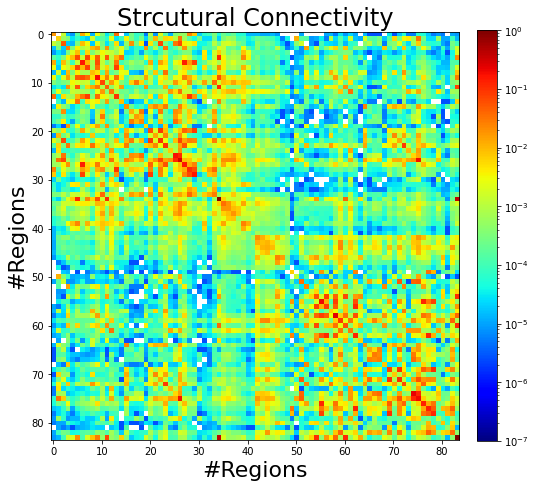

In [17]:
plt.figure(figsize=(8, 8))
norm = colors.LogNorm(1e-7, weights.max())
im = plt.imshow(weights,norm=norm,cmap=cm.jet)
plt.colorbar(im, fraction=0.046, pad=0.04)
plt.gca().set_title('Strcutural Connectivity', fontsize=24.0)
plt.ylabel('#Regions', fontsize=22.0)
plt.xlabel('#Regions', fontsize=22.0)

plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SCMatrix.png"), dpi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SCMatrix.svg"), dpi=800)
plt.show()

## ROIs chosen as Epileptogenic/propagation zones

In [18]:
hz_val=-3.65
pz_val=-2.4
ez_val=-1.6

ez_idx = np.array([6, 34],  dtype=np.int32)
pz_wplng_idx = np.array([5,11], dtype=np.int32)
pz_kplng_idx = np.array([27], dtype=np.int32)
pz_idx = np.append(pz_kplng_idx, pz_wplng_idx)

In [19]:
#Here, confidential medical information
weights[np.ix_(pz_kplng_idx, ez_idx)] = 4.0
weights[np.ix_(pz_wplng_idx, ez_idx)] = 1.0

weights[np.diag_indices(weights.shape[0])] = 0

In [20]:
SC=weights
SC.shape

(84, 84)

### Simulator

In [21]:
from BVEP_Simulator import VEP2Dmodel

### some simulations for  sanity check

In [22]:
T = 14.0
dt=0.1
ts = np.arange(0, T + dt, dt)

In [23]:
nt=ts.shape[0]
nt

141

In [24]:
nn=SC.shape[0]
nn

84

In [25]:
ns=nn
ns

84

In [26]:
tau=10.
sigma=0*10e-1
constants = np.array([tau, sigma])
constants

array([10.,  0.])

In [27]:
eta_true = np.ones(nn)*hz_val
eta_true[ez_idx] = ez_val
eta_true[pz_idx] = pz_val

In [28]:
K_true=1.

In [29]:
x_init=-2.5
z_init=3.5
init_conditions = np.array([x_init, z_init])

In [30]:
params_true = np.append(eta_true, K_true)
params_true.shape

(85,)

In [31]:
start_time = time.time()
Sim = VEP2Dmodel(params_true, constants, init_conditions, dt, ts, SC)
print(" single sim (sec) takes:" , (time.time() - start_time))

 single sim (sec) takes: 5.553886890411377


In [32]:
start_time = time.time()
Sim = VEP2Dmodel(params_true, constants, init_conditions, dt, ts, SC)
print(" single sim (sec) takes:" , (time.time() - start_time))

 single sim (sec) takes: 0.0031366348266601562


In [33]:
X=Sim.reshape(nn, int(Sim.shape[0]/nn))
X.shape

(84, 141)

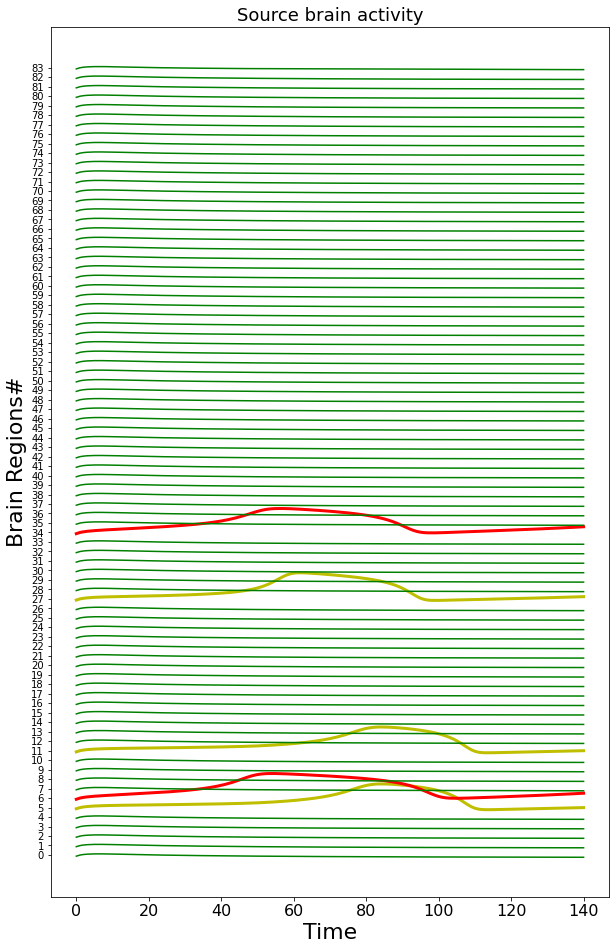

In [34]:
plt.figure(figsize=(10,16))
for i in range(0, nn):
    if i in ez_idx:
          plt.plot(X[i,:]+i, 'r', lw=3)
    elif i in pz_idx:
          plt.plot(X[i,:]+i, 'y', lw=3)
    else:  
          plt.plot(X[i,:]+i, 'g')
plt.yticks(np.r_[0:nn]-2, np.r_[0:nn],fontsize=10)
plt.xticks(fontsize=16)
plt.title("Source brain activity",fontsize=18)
plt.xlabel('Time',fontsize=22)
plt.ylabel('Brain Regions#',fontsize=22)
plt.show()

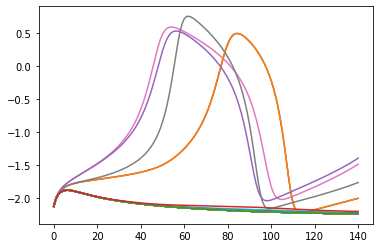

In [35]:
plt.plot(X.T);

In [36]:
Xn=Normalized(X)

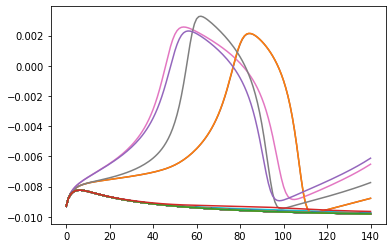

In [37]:
plt.plot(Xn.T);

### Data features

In [38]:
X=Xn

In [39]:
X_area = np.trapz(X, dx=0.0001)
X_area.shape

(84,)

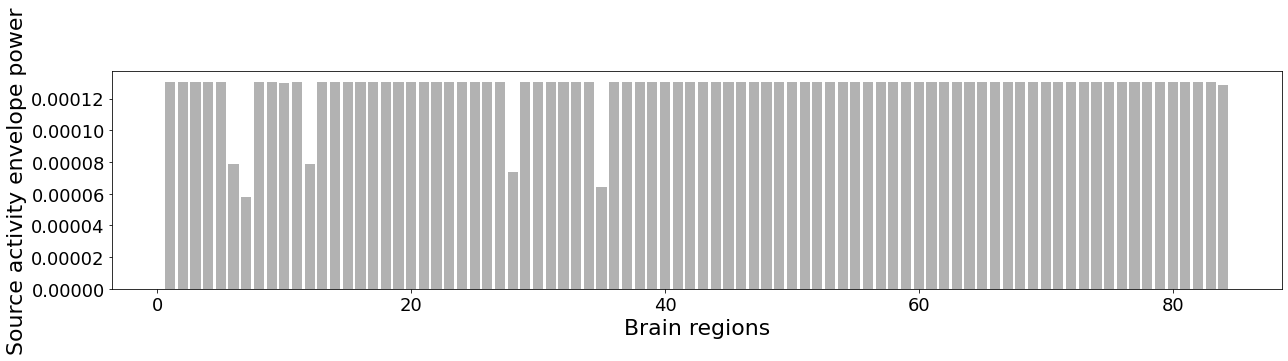

In [40]:
plt.figure(figsize=(18, 4))
plt.bar(np.arange(1,X_area.shape[0]+1), -X_area, color='black', alpha=0.3);
plt.xlabel('Brain regions', fontsize=22)
plt.ylabel('Source activity envelope power', fontsize=22)
plt.yticks(fontsize=18, rotation=0)
plt.xticks(fontsize=18, rotation=0)
plt.tight_layout()
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"Source_envelop_power.png"), dpi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"Source_envelop_power.svg"), dpi=800)
plt.show()

In [41]:
X_pwr = np.sum((X*X), axis=1)
X_pwr_n = 1-(X_pwr/ X_pwr.max())

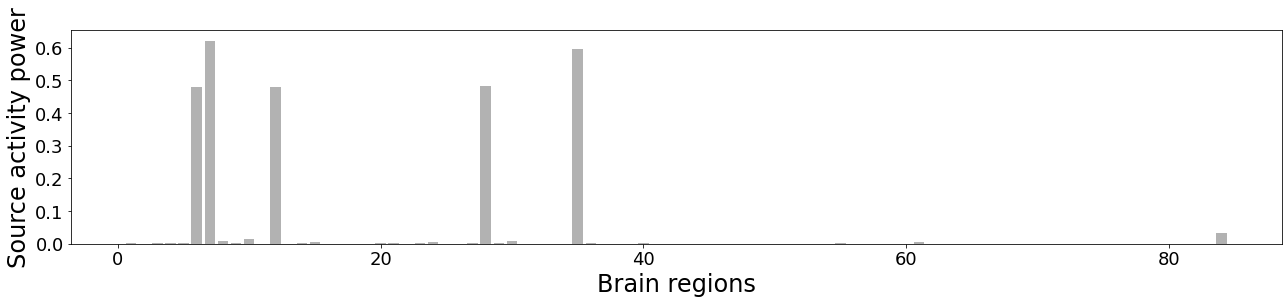

In [42]:
plt.figure(figsize=(18, 4))
plt.bar(np.arange(1,X_pwr.shape[0]+1), X_pwr_n, color='black', alpha=0.3);
plt.xlabel('Brain regions', fontsize=24)
plt.ylabel('Source activity power', fontsize=24)
plt.yticks(fontsize=18, rotation=0)
plt.xticks(fontsize=18, rotation=0)
plt.tight_layout()
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"Source_envelop_power_normalize.png"), dpi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"Source_envelop_power_normalize.svg"), dpi=800)
plt.show()

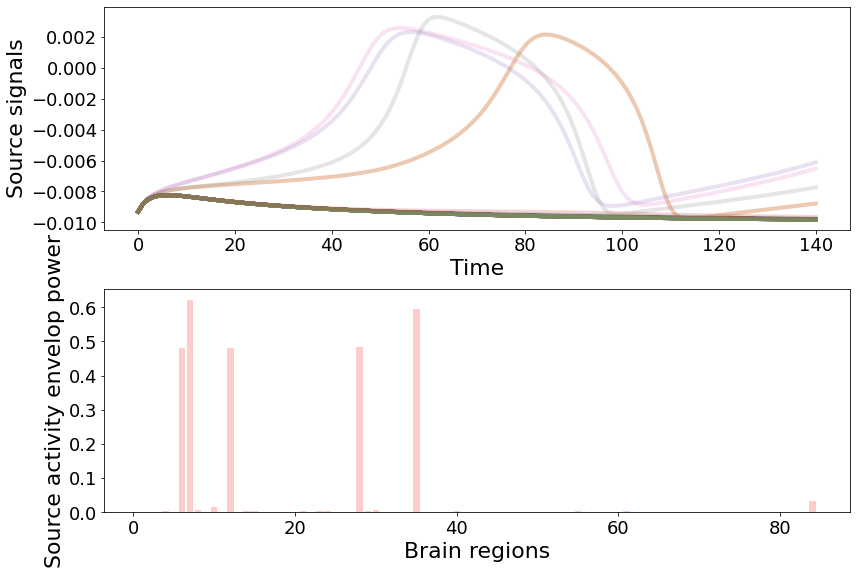

In [43]:
plt.figure(figsize=(12,8))
plt.subplot(211)
plt.plot(X.T, linewidth=4, alpha=0.2);
plt.xlabel('Time', fontsize=22)
plt.ylabel('Source signals', fontsize=22)
plt.yticks(fontsize=18, rotation=0)
plt.xticks(fontsize=18, rotation=0)

plt.subplot(212)
plt.bar(np.arange(1,X_pwr_n.shape[0]+1), X_pwr_n, color='r', alpha=0.2)
#plt.bar(np.arange(1,Seeg_area.shape[0]+1), Seeg_area, color='black', alpha=0.3);
plt.xlabel('Brain regions', fontsize=22)
plt.ylabel('Source activity envelop power', fontsize=22)
plt.yticks(fontsize=18, rotation=0)
plt.xticks(fontsize=18, rotation=0)
plt.tight_layout()
plt.show()

In [44]:
from BVEP_stat_summary import calculate_summary_statistics_features

In [45]:
nn, ns, nt

(84, 84, 141)

In [46]:
_=calculate_summary_statistics_features(Normalized(X).reshape(-1), nn, nt, dt, ts, features=['seizures_onset'])
num_features=_.shape[0]
print('feature shape:', num_features)

feature shape: 588


In [47]:
num_params=nn+1
num_params

85

### 1. Simulator wrapper

In [48]:
def VEP2Dmodel_source_simulator_wrapper(params):

    params = np.asarray(params)
    
    # time step
    T = 14.0
    dt=0.1
    ts = np.arange(0, T + dt, dt)

    # fixed parameters
    tau=10.
    sigma=0*10e-1
    constants = np.array([tau, sigma])
    
    nn=SC.shape[0]
    ns=nn
    nt=ts.shape[0]

    # initial conditions
    x_init=-2.5
    z_init=3.5
    init_conditions = np.array([x_init, z_init])
    
    Sim = VEP2Dmodel(params, constants, init_conditions, dt, ts, SC)

    #Source_signal=Sim.reshape(nn, int(Sim.shape[0]/nn))

    #summstats = torch.as_tensor(calculate_summary_statistics_features(Source_signal.reshape(-1),  nn, nt, dt, ts, features=['seizures_onset']))

    return Sim 

### 2. Prior over model parameters

In [49]:
nn+1

85

In [50]:
prior_min_eta=-5*np.ones(nn)
prior_min_K=0*np.ones(1)

prior_max_eta=-1*np.ones(nn)
prior_max_K=2*np.ones(1)

In [51]:
prior_min=np.append(prior_min_eta, prior_min_K)
prior_max=np.append(prior_max_eta, prior_max_K)

In [52]:
prior_min.shape, prior_max.shape

((85,), (85,))

In [53]:
prior = utils.torchutils.BoxUniform(low=torch.as_tensor(prior_min), high=torch.as_tensor(prior_max))

In [54]:
prior.sample().shape, prior.batch_shape, prior.event_shape

(torch.Size([85]), torch.Size([]), torch.Size([85]))

### 3. Simulation and inference

In [55]:
num_sim=10000

In [56]:
# start_time = time.time()

# posterior = infer(VEP2Dmodel_source_simulator_wrapper, prior, method='SNPE',  num_simulations=10000, num_workers=1)

# print ("-"*60)
# print("--- %s seconds ---" % (time.time() - start_time))

In [57]:
mysavepath = os.path.join(Res_dir, 'output_sim/simulated_theta_x.npz')
mysavepath

'Res_BVEP_ode_sbi_maf_sourcelevel_normed_onset_patient1_savesim_v18/output_sim/simulated_theta_x.npz'

In [58]:
def save_sims(simulator: Callable, prior, mysavepath, num_simulations: int):

    simulator, prior = prepare_for_sbi(simulator, prior)
    
    theta, x = simulate_for_sbi(
        simulator=simulator,
        proposal=prior,
        num_simulations=num_simulations,
        show_progress_bar=True,)
    
    #print(theta,flush=True)
    print( 'theta shape:',theta.shape,flush=True)
    #print(x,flush=True)
    print('data shape:', x.shape,flush=True)

    np.savez(mysavepath,theta=theta,x=x)


In [59]:
start_time = time.time()

save_sims(VEP2Dmodel_source_simulator_wrapper, prior, mysavepath, num_simulations=1)

print ("-"*60)
print("--- one sim took: %s seconds ---" % (time.time() - start_time))

theta shape: torch.Size([1, 85])
data shape: torch.Size([1, 11844])
------------------------------------------------------------
--- one sim took: 4.241731882095337 seconds ---


In [60]:
start_time = time.time()

save_sims(VEP2Dmodel_source_simulator_wrapper, prior, mysavepath, num_simulations=1)

print ("-"*60)
print("--- one sim with JIT took: %s seconds ---" % (time.time() - start_time))

theta shape: torch.Size([1, 85])
data shape: torch.Size([1, 11844])
------------------------------------------------------------
--- one sim with JIT took: 0.013876676559448242 seconds ---


In [61]:
start_time = time.time()

save_sims(VEP2Dmodel_source_simulator_wrapper, prior, mysavepath, num_simulations=num_sim)

print ("-"*60)
print("---all simulations took:  %s seconds ---" % (time.time() - start_time))

Running 10000 simulations.:   0%|          | 0/10000 [00:00<?, ?it/s]

theta shape: torch.Size([10000, 85])
data shape: torch.Size([10000, 11844])
------------------------------------------------------------
---all simulations took:  36.28944206237793 seconds ---


### Load simulations and calculate features

In [62]:
sim_deja=np.load(mysavepath)

In [63]:
theta_deja=sim_deja['theta']
x_deja=sim_deja['x']

In [64]:
print( 'theta shape:',theta_deja.shape,flush=True)
print('data shape:', x_deja.shape,flush=True)

theta shape: (10000, 85)
data shape: (10000, 11844)


In [65]:
x_deja_features=np.zeros((num_sim,num_features))
theta_deja_features=np.zeros((num_sim,num_params))

In [66]:
print( 'theta shape:',theta_deja_features.shape,flush=True)
print('data frature shape:', x_deja_features.shape,flush=True)

theta shape: (10000, 85)
data frature shape: (10000, 588)


In [67]:
start_time = time.time()

for i in range(num_sim):
    theta_deja_features[i,:]=theta_deja[i,:]
    x_deja_features[i,:]=calculate_summary_statistics_features(Normalized(x_deja)[i,:].reshape(-1), nn, nt, dt, ts, features=['seizures_onset'])
    
print ("-"*60)
print("---feature calculation took:  %s seconds ---" % (time.time() - start_time))

------------------------------------------------------------
---feature calculation took:  997.2488992214203 seconds ---


In [68]:
print( 'theta deja shape:',theta_deja_features.shape,flush=True)
print('data deja feature shape:', x_deja_features.shape,flush=True)

theta deja shape: (10000, 85)
data deja feature shape: (10000, 588)


In [69]:
np.isnan(np.sum(x_deja_features))

False

In [70]:
x = np.array(x_deja_features, dtype='float32')
x     = torch.as_tensor(x)

theta = np.array(theta_deja_features, dtype='float32')
theta = theta.reshape(theta.shape[0],num_params)
theta = torch.as_tensor(theta)

In [71]:
print( 'theta shape:',theta.shape,flush=True)
print('data feature shape:', x.shape,flush=True)

theta shape: torch.Size([10000, 85])
data feature shape: torch.Size([10000, 588])


### Inference

In [72]:
def myinfer_SNPE(prior, theta, x):
    
    inference = SNPE(prior, density_estimator='maf', device='cpu')
    _ = inference.append_simulations(theta, x).train()
    posterior = inference.build_posterior()

    return posterior

In [73]:
start_time = time.time()

posterior = myinfer_SNPE(prior, theta, x)

print ("-"*60)
print("--- Training neural network took: %s seconds ---" % (time.time() - start_time))

 Neural network successfully converged after 504 epochs.------------------------------------------------------------
--- Training neural network took: 1013.7224638462067 seconds ---


### Data

In [74]:
obs_source =VEP2Dmodel(params_true, constants, init_conditions, dt, ts, SC)
obs_source=obs_source.reshape(nn, int(obs_source.shape[0]/nn))

In [75]:
obs_summary_statistics=calculate_summary_statistics_features(Normalized(obs_source).reshape(-1),  nn, nt, dt, ts, features=['seizures_onset'])

In [76]:
obs_source.shape, obs_summary_statistics.shape

((84, 141), (588,))

In [77]:
y_obs=obs_source
y_obs.shape

(84, 141)

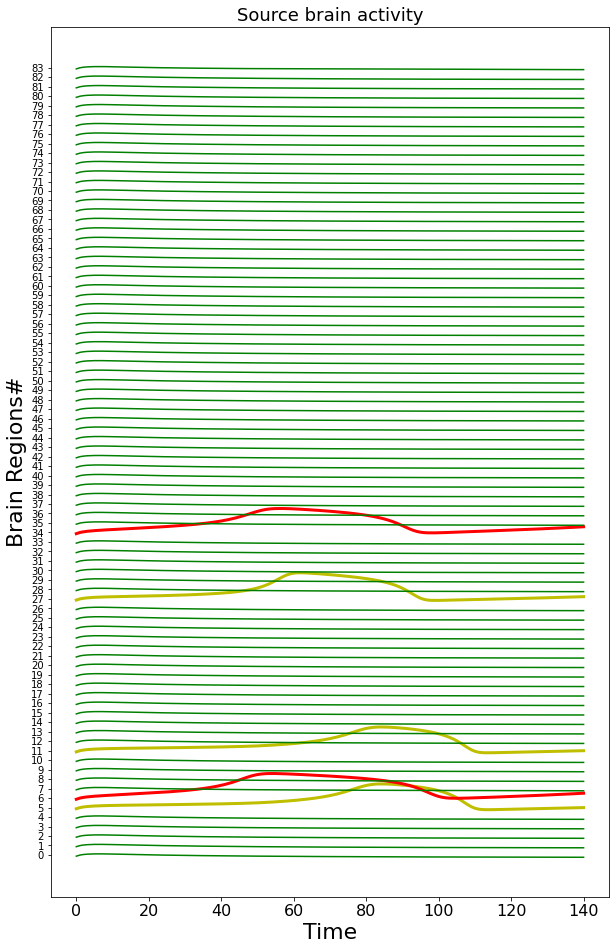

In [78]:
plt.figure(figsize=(10,16))
for i in range(0, nn):
    if i in ez_idx:
          plt.plot(obs_source[i,:]+i, 'r', lw=3)
    elif i in pz_idx:
          plt.plot(obs_source[i,:]+i, 'y', lw=3)
    else:  
          plt.plot(obs_source[i,:]+i, 'g')
plt.yticks(np.r_[0:nn]-2, np.r_[0:nn],fontsize=10)
plt.xticks(fontsize=16)
plt.title("Source brain activity",fontsize=18)
plt.xlabel('Time',fontsize=22)
plt.ylabel('Brain Regions#',fontsize=22)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SBI_BVEP_ode_obs_source_K_"+str(K_true)+".png"), dpi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SBI_BVEP_ode_obs_source_K_"+str(K_true)+".svg"), dpi=800)
plt.show()

### Posterior

In [79]:
from sklearn.metrics import confusion_matrix
from BVEP_SME import SME_labels, SEM_violinplot, plot_confusion_matrix, plot_zscore_shrinkage, plot_roc_curve, true_node_binary, estimated_node_binary, SME_accuracy

In [80]:
nodes=np.r_[0:nn]

In [81]:
num_samples=200

In [82]:
start_time = time.time()

posterior_samples = posterior.sample((num_samples,), obs_summary_statistics).numpy()

print ("-"*60)
print("--- sampling took: %s seconds ---" % (time.time() - start_time))

Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

------------------------------------------------------------
--- sampling took: 0.7977192401885986 seconds ---


In [83]:
posterior_samples.shape, params_true.shape

((200, 85), (85,))

In [84]:
np.save(os.path.join(cwd+'/'+str(Res_dir), 'BVEP_ode_sbi_sourcelevel_patient1_posteriorsamples.npy') , posterior_samples)

In [85]:
eta_posterior=posterior_samples[:,:-1]
K_posterior=posterior_samples[:,-1]

In [86]:
K_posterior.mean(), K_posterior.std()

(1.1042407, 0.4002813)

In [87]:
eta_c=-1.95
delta_eta=1.0              

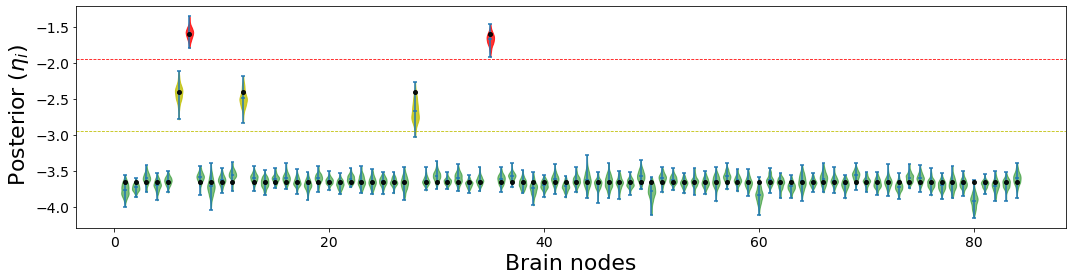

In [88]:
plt.figure(figsize=(15,4))
SEM_violinplot(nn, eta_true, ez_idx, pz_idx, eta_posterior, eta_c, delta_eta )
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SBI_BVEP_ode_InferredExcitability_K_"+str(K_true)+".png"), dpi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SBI_BVEP_ode_InferredExcitability_K_"+str(K_true)+".svg"), dpi=800)
plt.show()

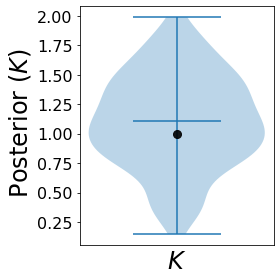

In [89]:
plt.figure(figsize=(4,4))
parts= plt.violinplot(K_posterior, widths=0.7, showmeans=True, showextrema=True);
plt.plot(1,params_true[-1] ,'o', color='k', alpha=0.9, markersize=8)
plt.ylabel(' Posterior ' +r'${(K)}$', fontsize=24);  
plt.xlabel(r'${K}$', fontsize=24); 
plt.yticks(fontsize=16)
plt.xticks([])
plt.tight_layout()
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SBI_BVEP_ode_InferredCoupling_K_"+str(K_true)+".png"), dpi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SBI_BVEP_ode_InferredCoupling_K_"+str(K_true)+".svg"), dpi=800)
plt.show()

In [90]:
estimated_posterior=np.percentile(posterior_samples, [50], axis=0).reshape(-1)    

In [91]:
y_fit_source =VEP2Dmodel(estimated_posterior, constants, init_conditions, dt, ts, SC)

yfit_source=y_fit_source.reshape(nn, int(y_fit_source.shape[0]/nn))

In [92]:
y_fit=yfit_source
y_fit.shape

(84, 141)

In [93]:
np.save(os.path.join(cwd+'/'+str(Res_dir), 'BVEP_ode_sbi_sourcelevel_patient1_y_obs.npy') , y_obs)
np.save(os.path.join(cwd+'/'+str(Res_dir), 'BVEP_ode_sbi_sourcelevel_patient1_y_fit.npy') , y_fit)

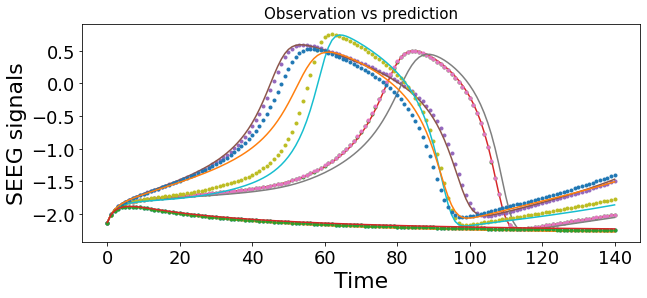

In [94]:
Rois=np.array([1, 5, 6, 11, 27, 34, 50])

plt.figure(figsize=(10,4))
for roi in Rois:
    plt.plot(y_obs.T[:,roi], '.')
    plt.plot(y_fit.T[:,roi] )
plt.title("Observation vs prediction",fontsize=15)
plt.xlabel('Time', fontsize=22)
plt.ylabel('SEEG signals', fontsize=22)
plt.yticks(fontsize=18, rotation=0)
plt.xticks(fontsize=18, rotation=0)
plt.show()

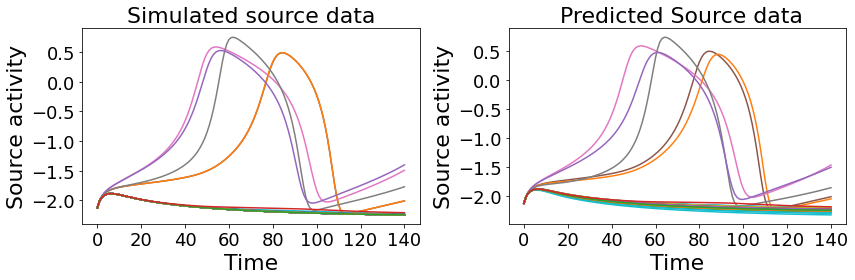

In [95]:
plt.figure(figsize=(12,4))

plt.subplot(121);
plt.plot(y_obs.T)
plt.title("Simulated source data", fontsize=22) 
plt.xlabel('Time', fontsize=22)
plt.ylabel('Source activity', fontsize=22)
plt.yticks(fontsize=18, rotation=0)
plt.xticks(fontsize=18, rotation=0)

plt.subplot(122)
plt.plot(y_fit.T)
plt.title(" Predicted Source data", fontsize=22) 
plt.xlabel('Time', fontsize=22)
plt.ylabel('Source activity', fontsize=22)
plt.yticks(fontsize=18, rotation=0)
plt.xticks(fontsize=18, rotation=0)
plt.tight_layout()
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SBI_FittedBVEP_ode_observation_K_"+str(K_true)+".png"), dpi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SBI_FittedBVEP_ode_observation_K_"+str(K_true)+".svg"), dpi=800)
plt.show()

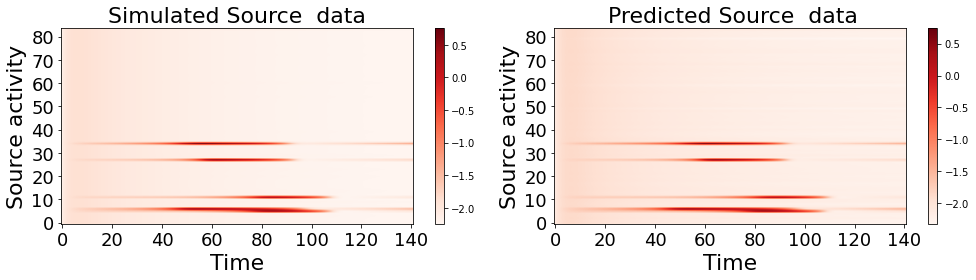

In [96]:
plt.figure(figsize=(14, 4))
plt.subplot(121);
plt.imshow(y_obs, aspect='auto', interpolation='bilinear',  origin='lower', cmap='Reds')
plt.title("Simulated Source  data", fontsize=22) 
plt.xlabel('Time', fontsize=22)
plt.ylabel('Source activity', fontsize=22)
plt.yticks(fontsize=18, rotation=0)
plt.xticks(fontsize=18, rotation=0)
plt.colorbar();

plt.subplot(122)
plt.imshow(y_fit, aspect='auto', interpolation='bilinear',  origin='lower', cmap='Reds')
plt.title(" Predicted Source  data", fontsize=22) 
plt.xlabel('Time', fontsize=22)
plt.ylabel('Source activity', fontsize=22)
plt.yticks(fontsize=18, rotation=0)
plt.xticks(fontsize=18, rotation=0) 
plt.colorbar();

plt.tight_layout()
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SBI_ImshowFittedBVEP_ode_observation_K_"+str(K_true)+".png"), dpi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SBI_ImshowFittedBVEP_ode_observation_K_"+str(K_true)+".svg"), dpi=800)
plt.show()

In [97]:
eta_true.shape, eta_posterior.shape

((84,), (200, 84))

In [98]:
true_labels_nodes,est_labels_nodes =SME_labels(eta_true, eta_posterior.transpose(), eta_c, delta_eta)

In [99]:
Confusion_matrix_values= confusion_matrix(true_labels_nodes, est_labels_nodes, labels=["EZ", "PZ", "HZ"])
print('Confusion_matrix_values= \n', Confusion_matrix_values)

Confusion_matrix_values= 
 [[ 2  0  0]
 [ 0  3  0]
 [ 0  0 79]]


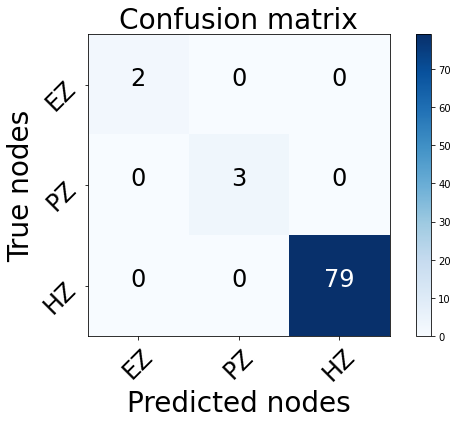

In [100]:
plt.figure(figsize=(8, 6))
plot_confusion_matrix(Confusion_matrix_values, ["EZ", "PZ", "HZ"])
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SBI_BVEP_ode_ConfusionMatrix_K_"+str(K_true)+".png"), dpi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SBI_BVEP_ode_ConfusionMatrix_K_"+str(K_true)+".svg"), dpi=800)
plt.tight_layout()
plt.show()

In [101]:
np.sum(np.std(eta_posterior, axis=0))

5.8253665

In [102]:
from report_metrics import LSE, Err, RMSE, LSE_obs, z_score, shrinkage

In [103]:
eta_est_mu=np.mean(eta_posterior, axis=0)
eta_est_std=np.std(eta_posterior, axis=0)

In [104]:
b=-7
a=-1
prior_std =np.sqrt((1/12)*(b-a)**2)

In [105]:
def plot_zscore_shrinkage(nodes, eta_true, eta_est_mu, eta_est_std, prior_std):
    z_score_eta=z_score(eta_true, eta_est_mu, eta_est_std)
    colors= np.random.rand(z_score_eta.shape[0])
    plt.scatter(shrinkage([prior_std]*nodes.shape[0], eta_est_std), z_score_eta ,s=120, c='blue')
    plt.xlabel("Posterior shrinkages", fontsize=24)
    plt.ylabel("Posterior z-scores", fontsize=24)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)

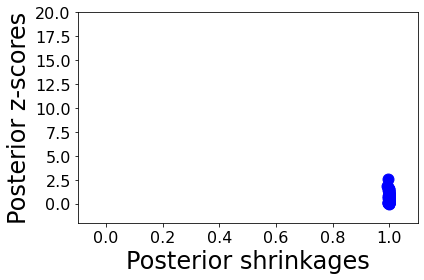

In [106]:
plot_zscore_shrinkage(nodes, eta_true, eta_est_mu, eta_est_std, prior_std)
plt.axis((-.1,1.1,-2,20))
plt.tight_layout()
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SBI_BVEP_ode_zscore_shrinkage_K_"+str(K_true)+".png"), dpi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SBI_BVEP_ode_zscore_shrinkage_K_"+str(K_true)+".svg"), dpi=800)
plt.show()

In [107]:
Err(eta_true, eta_est_mu), RMSE(eta_true, eta_est_mu)

(3.6603260278701786, 0.06461603922231623)

In [108]:
Err(y_obs, y_fit), RMSE(y_obs, y_fit)

(164.98498671420361, 0.03389752073574615)

In [109]:
shrinkage([prior_std]*nodes.shape[0], eta_est_std).shape

(84,)

In [110]:
from sklearn import metrics
from itertools import cycle
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.preprocessing import label_binarize

In [111]:
n_classes=3
node_classes=['HZ', 'PZ', 'EZ']

In [112]:
true_nodes=true_node_binary(true_labels_nodes)
estimated_nodes=estimated_node_binary(est_labels_nodes)

In [113]:
y_true=label_binarize(true_nodes, classes=[0, 1, 2])
y_pred=label_binarize(estimated_nodes, classes=[0, 1, 2])

In [114]:
y_true.shape, y_pred.shape

((84, 3), (84, 3))

In [115]:
fpr = dict()
tpr = dict()
roc_auc = dict()


for i in range(n_classes):
    fpr[i], tpr[i], _ = metrics.roc_curve(y_true[:, i], y_pred[:, i])
    roc_auc[i] = metrics.auc(fpr[i], tpr[i])
    
# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = metrics.roc_curve(y_true.ravel(), y_pred.ravel())
roc_auc["micro"] = metrics.auc(fpr["micro"], tpr["micro"])    


all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = metrics.auc(fpr["macro"], tpr["macro"])

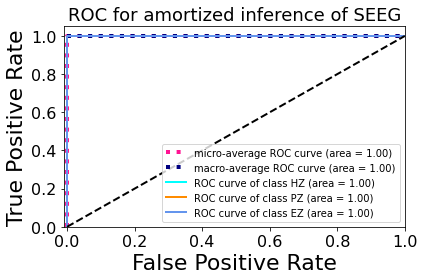

In [116]:
# Plot all ROC curves
plt.figure()

plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
lw=2

for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class '+ str(node_classes[i])+' (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([-.01, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=22)
plt.ylabel('True Positive Rate', fontsize=22)
plt.title('ROC for amortized inference of SEEG', fontsize=18)
plt.legend(loc="lower right")
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.tight_layout()
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"ROC_K_"+str(K_true)+".png"), dpi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"ROC_K_"+str(K_true)+".png"), dpi=800)
plt.show()

In [117]:
fpr

{0: array([0., 0., 1.]),
 1: array([0., 0., 1.]),
 2: array([0., 0., 1.]),
 'micro': array([0., 0., 1.]),
 'macro': array([0., 1.])}

In [118]:
tpr

{0: array([0., 1., 1.]),
 1: array([0., 1., 1.]),
 2: array([0., 1., 1.]),
 'micro': array([0., 1., 1.]),
 'macro': array([1., 1.])}

In [119]:
roc_auc["micro"], roc_auc["macro"]

(1.0, 1.0)

### Another Data set

In [120]:
hz_val=-3.65
pz_val=-2.5
ez_val=-1.7


ez_idx = np.array([7, 29],  dtype=np.int32)
pz_wplng_idx = np.array([6, 9, 28], dtype=np.int32)
pz_kplng_idx = np.array([27], dtype=np.int32)
pz_idx = np.append(pz_kplng_idx, pz_wplng_idx)

In [121]:
eta_true = np.ones(nn)*hz_val
eta_true[ez_idx] = ez_val
eta_true[pz_idx] = pz_val

In [122]:
K_true=1.

In [123]:
x_init=-2.5
z_init=3.5
init_conditions = np.array([x_init, z_init])

In [124]:
params_true = np.append(eta_true, K_true)
params_true.shape

(85,)

In [125]:
obs_source =VEP2Dmodel(params_true, constants, init_conditions, dt, ts, SC)
obs_source=obs_source.reshape(nn, int(obs_source.shape[0]/nn))

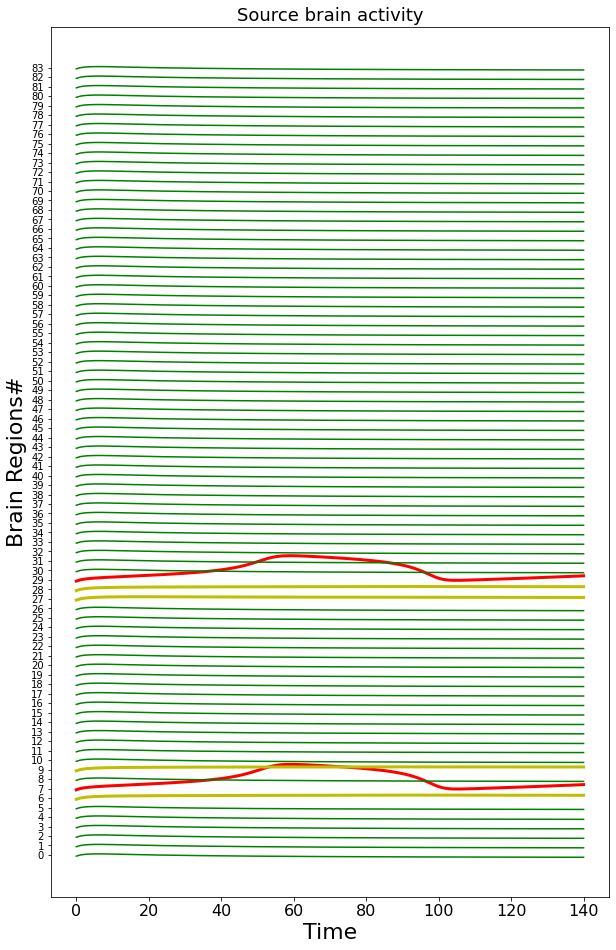

In [126]:
plt.figure(figsize=(10,16))
for i in range(0, nn):
    if i in ez_idx:
          plt.plot(obs_source[i,:]+i, 'r', lw=3)
    elif i in pz_idx:
          plt.plot(obs_source[i,:]+i, 'y', lw=3)
    else:  
          plt.plot(obs_source[i,:]+i, 'g')
plt.yticks(np.r_[0:nn]-2, np.r_[0:nn],fontsize=10)
plt.xticks(fontsize=16)
plt.title("Source brain activity",fontsize=18)
plt.xlabel('Time',fontsize=22)
plt.ylabel('Brain Regions#',fontsize=22)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SBI_BVEP_ode_obs2_source_K_"+str(K_true)+".png"), dpi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SBI_BVEP_ode_obs2_source_K_"+str(K_true)+".svg"), dpi=800)
plt.show()

In [127]:
obs_summary_statistics=calculate_summary_statistics_features(Normalized(obs_source).reshape(-1),  nn, nt, dt, ts, features=['seizures_onset'])

In [128]:
obs_source.shape, obs_summary_statistics.shape

((84, 141), (588,))

In [129]:
y_obs=obs_source
y_obs.shape

(84, 141)

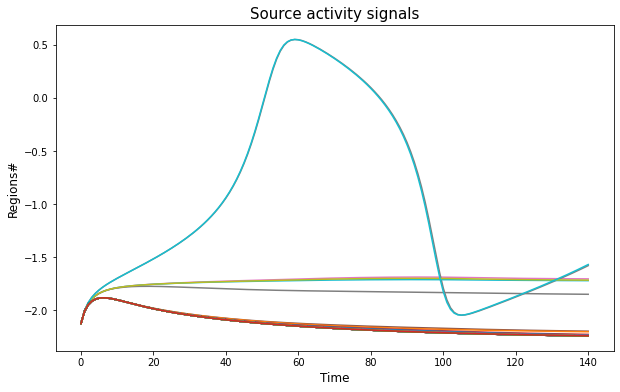

In [130]:
plt.figure(figsize=(10,6))
plt.plot(obs_source.T)
plt.title("Source activity signals",fontsize=15)
plt.xlabel('Time',fontsize=12)
plt.ylabel('Regions#',fontsize=12)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SBI_BVEP_ode_obs2_seeg_K_"+str(K_true)+".png"), dpi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SBI_BVEP_ode_obs2_seeg_K_"+str(K_true)+".svg"), dpi=800)

### Posterior

In [131]:
nodes=np.r_[0:nn]

In [132]:
num_samples=200

In [133]:
start_time = time.time()

posterior_samples = posterior.sample((num_samples,), obs_summary_statistics).numpy()

print ("-"*60)
print("--- sampling took: %s seconds ---" % (time.time() - start_time))

Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

------------------------------------------------------------
--- sampling took: 0.8872747421264648 seconds ---


In [134]:
posterior_samples.shape, params_true.shape

((200, 85), (85,))

In [135]:
np.save(os.path.join(cwd+'/'+str(Res_dir), 'BVEP_ode_sbi_sourcelevel_obs2_patient1_posteriorsamples.npy') , posterior_samples)

In [136]:
eta_posterior=posterior_samples[:,:-1]
K_posterior=posterior_samples[:,-1]

In [137]:
K_posterior.mean(), K_posterior.std()

(1.2153217, 0.3981837)

In [138]:
eta_c=-1.95
delta_eta=1.0              

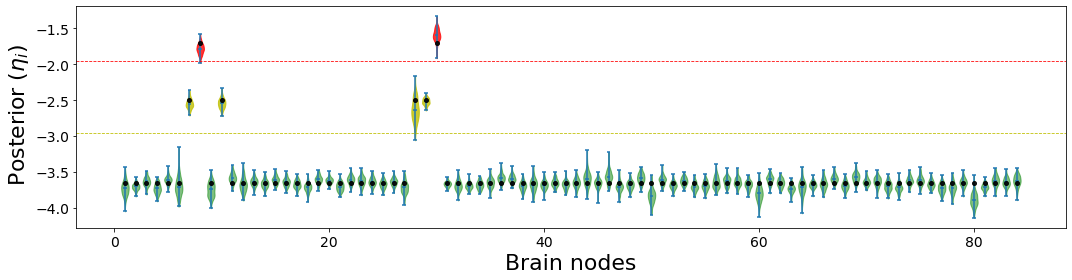

In [139]:
plt.figure(figsize=(15,4))
SEM_violinplot(nn, eta_true, ez_idx, pz_idx, eta_posterior, eta_c, delta_eta )
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SBI_BVEP_ode_obs2_InferredExcitability_K_"+str(K_true)+".png"), dpi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SBI_BVEP_ode_obs2_InferredExcitability_K_"+str(K_true)+".svg"), dpi=800)
plt.show()

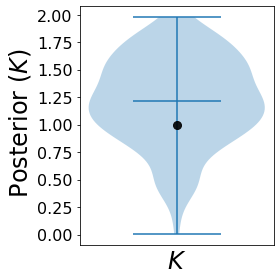

In [140]:
plt.figure(figsize=(4,4))
parts= plt.violinplot(K_posterior, widths=0.7, showmeans=True, showextrema=True);
plt.plot(1,params_true[-1] ,'o', color='k', alpha=0.9, markersize=8)
plt.ylabel(' Posterior ' +r'${(K)}$', fontsize=24);  
plt.xlabel(r'${K}$', fontsize=24); 
plt.yticks(fontsize=16)
plt.xticks([])
plt.tight_layout()
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SBI_BVEP_ode_obs2_InferredCoupling_K_"+str(K_true)+".png"), dpi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SBI_BVEP_ode_obs2_InferredCoupling_K_"+str(K_true)+".svg"), dpi=800)
plt.show()

In [141]:
estimated_posterior=np.percentile(posterior_samples, [50], axis=0).reshape(-1)    

In [142]:
y_fit_source =VEP2Dmodel(estimated_posterior, constants, init_conditions, dt, ts, SC)

yfit_source=y_fit_source.reshape(nn, int(y_fit_source.shape[0]/nn))


In [143]:
y_fit=yfit_source
y_fit.shape

(84, 141)

In [144]:
np.save(os.path.join(cwd+'/'+str(Res_dir), 'BVEP_ode_sbi_sourcelevel_obs2_patient1_y_obs.npy') , y_obs)
np.save(os.path.join(cwd+'/'+str(Res_dir), 'BVEP_ode_sbi_sourcelevel_obs2_patient1_y_fit.npy') , y_fit)

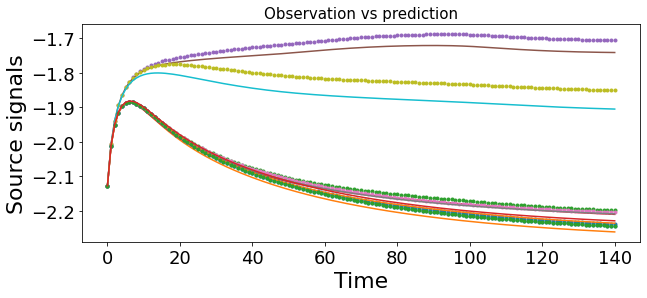

In [145]:
Rois=np.array([1, 5, 6, 11, 27, 34, 50])

plt.figure(figsize=(10,4))
for roi in Rois:
    plt.plot(y_obs.T[:,roi], '.')
    plt.plot(y_fit.T[:,roi] )
plt.title("Observation vs prediction",fontsize=15)
plt.xlabel('Time', fontsize=22)
plt.ylabel('Source signals', fontsize=22)
plt.yticks(fontsize=18, rotation=0)
plt.xticks(fontsize=18, rotation=0)
plt.show()

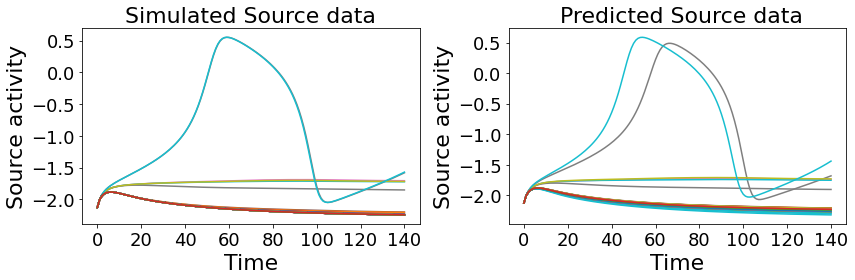

In [146]:
plt.figure(figsize=(12,4))

plt.subplot(121);
plt.plot(y_obs.T)
plt.title("Simulated Source data", fontsize=22) 
plt.xlabel('Time', fontsize=22)
plt.ylabel('Source activity', fontsize=22)
plt.yticks(fontsize=18, rotation=0)
plt.xticks(fontsize=18, rotation=0)

plt.subplot(122)
plt.plot(y_fit.T)
plt.title(" Predicted Source data", fontsize=22) 
plt.xlabel('Time', fontsize=22)
plt.ylabel('Source activity', fontsize=22)
plt.yticks(fontsize=18, rotation=0)
plt.xticks(fontsize=18, rotation=0)
plt.tight_layout()
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SBI_FittedBVEP_ode_obs2_observation_K_"+str(K_true)+".png"), dpi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SBI_FittedBVEP_ode_obs2_observation_K_"+str(K_true)+".svg"), dpi=800)
plt.show()

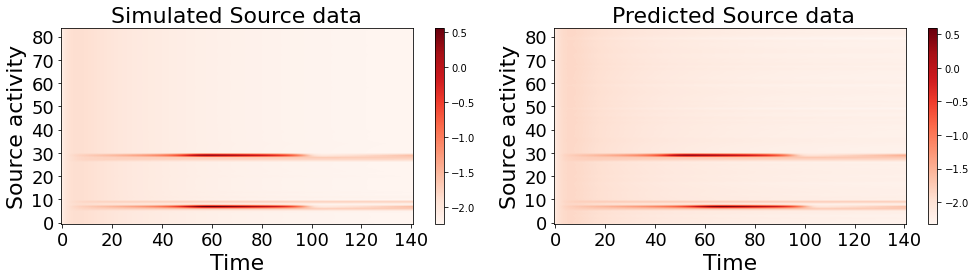

In [147]:
plt.figure(figsize=(14, 4))
plt.subplot(121);
plt.imshow(y_obs, aspect='auto', interpolation='bilinear',  origin='lower', cmap='Reds')
plt.title("Simulated Source data", fontsize=22) 
plt.xlabel('Time', fontsize=22)
plt.ylabel('Source activity', fontsize=22)
plt.yticks(fontsize=18, rotation=0)
plt.xticks(fontsize=18, rotation=0)
plt.colorbar();

plt.subplot(122)
plt.imshow(y_fit, aspect='auto', interpolation='bilinear',  origin='lower', cmap='Reds')
plt.title(" Predicted Source data", fontsize=22) 
plt.xlabel('Time', fontsize=22)
plt.ylabel('Source activity', fontsize=22)
plt.yticks(fontsize=18, rotation=0)
plt.xticks(fontsize=18, rotation=0) 
plt.colorbar();

plt.tight_layout()
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SBI_ImshowFittedBVEP_ode_obs2_observation_K_"+str(K_true)+".png"), dpi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SBI_ImshowFittedBVEP_ode_obs2_observation_K_"+str(K_true)+".svg"), dpi=800)
plt.show()

In [148]:
eta_true.shape, eta_posterior.shape

((84,), (200, 84))

In [149]:
true_labels_nodes,est_labels_nodes =SME_labels(eta_true, eta_posterior.transpose(), eta_c, delta_eta)

In [150]:
Confusion_matrix_values= confusion_matrix(true_labels_nodes, est_labels_nodes, labels=["EZ", "PZ", "HZ"])
print('Confusion_matrix_values= \n', Confusion_matrix_values)

Confusion_matrix_values= 
 [[ 2  0  0]
 [ 0  4  0]
 [ 0  0 78]]


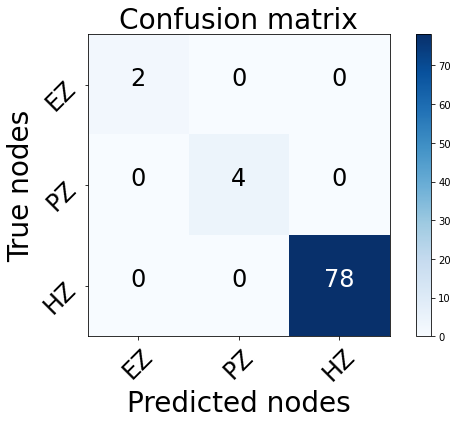

In [151]:
plt.figure(figsize=(8, 6))
plot_confusion_matrix(Confusion_matrix_values, ["EZ", "PZ", "HZ"])
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SBI_BVEP_ode_obs2_ConfusionMatrix_K_"+str(K_true)+".png"), dpi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SBI_BVEP_ode_obs2_ConfusionMatrix_K_"+str(K_true)+".svg"), dpi=800)
plt.tight_layout()
plt.show()

In [152]:
np.sum(np.std(eta_posterior, axis=0))

5.7599974

In [153]:
from report_metrics import LSE, Err, RMSE, LSE_obs, z_score, shrinkage

In [154]:
eta_est_mu=np.mean(eta_posterior, axis=0)
eta_est_std=np.std(eta_posterior, axis=0)

In [155]:
b=-7
a=-1
prior_std =np.sqrt((1/12)*(b-a)**2)

In [156]:
def plot_zscore_shrinkage(nodes, eta_true, eta_est_mu, eta_est_std, prior_std):
    z_score_eta=z_score(eta_true, eta_est_mu, eta_est_std)
    colors= np.random.rand(z_score_eta.shape[0])
    plt.scatter(shrinkage([prior_std]*nodes.shape[0], eta_est_std), z_score_eta ,s=120, c='blue')
    plt.xlabel("Posterior shrinkages", fontsize=24)
    plt.ylabel("Posterior z-scores", fontsize=24)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)

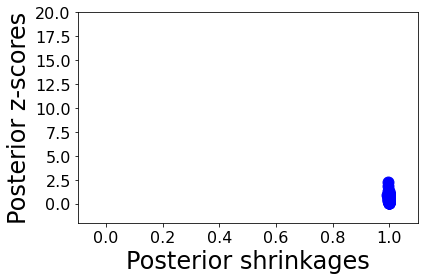

In [157]:
plot_zscore_shrinkage(nodes, eta_true, eta_est_mu, eta_est_std, prior_std)
plt.axis((-.1,1.1,-2,20))
plt.tight_layout()
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SBI_BVEP_ode_obs2_zscore_shrinkage_K_"+str(K_true)+".png"), dpi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SBI_BVEP_ode_obs2_zscore_shrinkage_K_"+str(K_true)+".svg"), dpi=800)
plt.show()

In [158]:
Err(eta_true, eta_est_mu), RMSE(eta_true, eta_est_mu)

(3.762577319145203, 0.05854534037546924)

In [159]:
Err(y_obs, y_fit), RMSE(y_obs, y_fit)

(174.6648613196914, 0.03699841798474682)

In [160]:
shrinkage([prior_std]*nodes.shape[0], eta_est_std).shape

(84,)

In [161]:
from sklearn import metrics
from itertools import cycle
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.preprocessing import label_binarize

In [162]:
n_classes=3
node_classes=['HZ', 'PZ', 'EZ']

In [163]:
true_nodes=true_node_binary(true_labels_nodes)
estimated_nodes=estimated_node_binary(est_labels_nodes)

In [164]:
y_true=label_binarize(true_nodes, classes=[0, 1, 2])
y_pred=label_binarize(estimated_nodes, classes=[0, 1, 2])

In [165]:
y_true.shape, y_pred.shape

((84, 3), (84, 3))

In [166]:
fpr = dict()
tpr = dict()
roc_auc = dict()


for i in range(n_classes):
    fpr[i], tpr[i], _ = metrics.roc_curve(y_true[:, i], y_pred[:, i])
    roc_auc[i] = metrics.auc(fpr[i], tpr[i])
    
# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = metrics.roc_curve(y_true.ravel(), y_pred.ravel())
roc_auc["micro"] = metrics.auc(fpr["micro"], tpr["micro"])    


all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = metrics.auc(fpr["macro"], tpr["macro"])

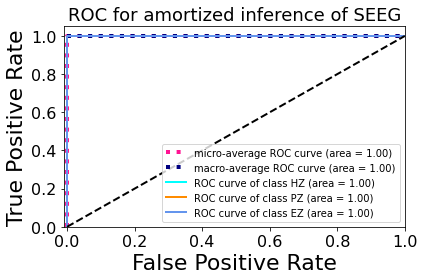

In [167]:
# Plot all ROC curves
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class '+ str(node_classes[i])+' (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([-.01, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=22)
plt.ylabel('True Positive Rate', fontsize=22)
plt.title('ROC for amortized inference of SEEG', fontsize=18)
plt.legend(loc="lower right")
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.tight_layout()
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"ROC_obs2_K_"+str(K_true)+".png"), dpi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"ROC_obs2_K_"+str(K_true)+".png"), dpi=800)
plt.show()

In [168]:
fpr

{0: array([0., 0., 1.]),
 1: array([0., 0., 1.]),
 2: array([0., 0., 1.]),
 'micro': array([0., 0., 1.]),
 'macro': array([0., 1.])}

In [169]:
tpr

{0: array([0., 1., 1.]),
 1: array([0., 1., 1.]),
 2: array([0., 1., 1.]),
 'micro': array([0., 1., 1.]),
 'macro': array([1., 1.])}

In [170]:
roc_auc["micro"], roc_auc["macro"]

(1.0, 1.0)

### Another Data set

In [171]:
hz_val=-3.65
pz_val=-2.4
ez_val=-1.6

ez_idx = np.array([6, 34, 18, 45, 67, 81],  dtype=np.int32)
pz_wplng_idx = np.array([5,11], dtype=np.int32)
pz_kplng_idx = np.array([27], dtype=np.int32)
pz_idx = np.append(pz_kplng_idx, pz_wplng_idx)

In [172]:
eta_true = np.ones(nn)*hz_val
eta_true[ez_idx] = ez_val
eta_true[pz_idx] = pz_val

In [173]:
K_true=1.

In [174]:
x_init=-2.5
z_init=3.5
init_conditions = np.array([x_init, z_init])

In [175]:
params_true = np.append(eta_true, K_true)
params_true.shape

(85,)

In [176]:
obs_source =VEP2Dmodel(params_true, constants, init_conditions, dt, ts, SC)
obs_source=obs_source.reshape(nn, int(obs_source.shape[0]/nn))

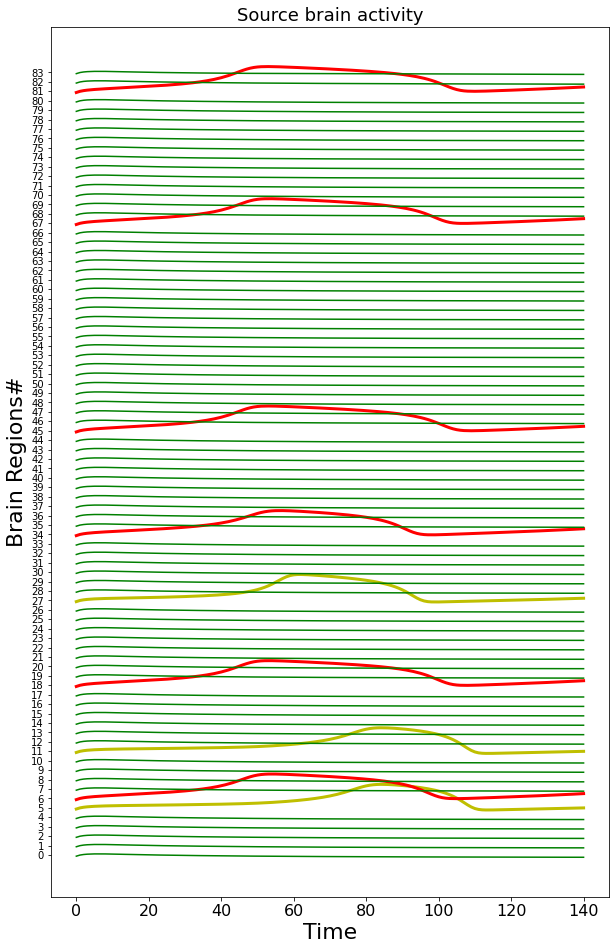

In [177]:
plt.figure(figsize=(10,16))
for i in range(0, nn):
    if i in ez_idx:
          plt.plot(obs_source[i,:]+i, 'r', lw=3)
    elif i in pz_idx:
          plt.plot(obs_source[i,:]+i, 'y', lw=3)
    else:  
          plt.plot(obs_source[i,:]+i, 'g')
plt.yticks(np.r_[0:nn]-2, np.r_[0:nn],fontsize=10)
plt.xticks(fontsize=16)
plt.title("Source brain activity",fontsize=18)
plt.xlabel('Time',fontsize=22)
plt.ylabel('Brain Regions#',fontsize=22)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SBI_BVEP_ode_obs3_source_K_"+str(K_true)+".png"), dpi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SBI_BVEP_ode_obs3_source_K_"+str(K_true)+".svg"), dpi=800)
plt.show()

In [178]:
obs_summary_statistics=calculate_summary_statistics_features(Normalized(obs_source).reshape(-1),  nn, nt, dt, ts, features=['seizures_onset'])

In [179]:
obs_source.shape, obs_summary_statistics.shape

((84, 141), (588,))

In [180]:
y_obs=obs_source
y_obs.shape

(84, 141)

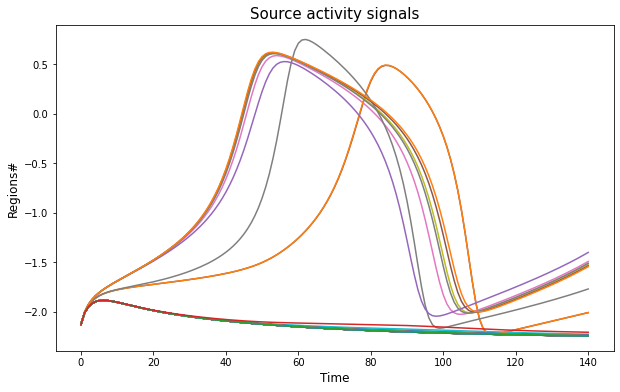

In [181]:
plt.figure(figsize=(10,6))
plt.plot(obs_source.T)
plt.title("Source activity signals",fontsize=15)
plt.xlabel('Time',fontsize=12)
plt.ylabel('Regions#',fontsize=12)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SBI_BVEP_ode_obs3_seeg_K_"+str(K_true)+".png"), dpi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SBI_BVEP_ode_obs3_seeg_K_"+str(K_true)+".svg"), dpi=800)

### Posterior

In [182]:
nodes=np.r_[0:nn]

In [183]:
num_samples=200

In [184]:
start_time = time.time()

posterior_samples = posterior.sample((num_samples,), obs_summary_statistics).numpy()

print ("-"*60)
print("--- sampling took: %s seconds ---" % (time.time() - start_time))

Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

------------------------------------------------------------
--- sampling took: 0.5515015125274658 seconds ---


In [185]:
posterior_samples.shape, params_true.shape

((200, 85), (85,))

In [186]:
np.save(os.path.join(cwd+'/'+str(Res_dir), 'BVEP_ode_sbi_sourcelevel_obs3_patient1_posteriorsamples.npy') , posterior_samples)

In [187]:
eta_posterior=posterior_samples[:,:-1]
K_posterior=posterior_samples[:,-1]

In [188]:
K_posterior.mean(), K_posterior.std()

(1.2280071, 0.35938644)

In [189]:
eta_c=-1.95
delta_eta=1.0              

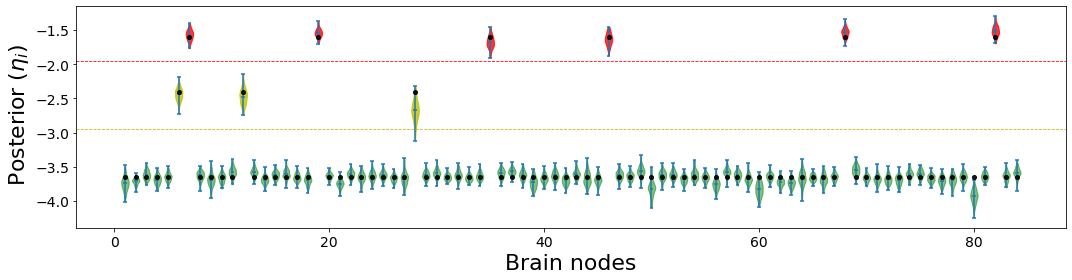

In [190]:
plt.figure(figsize=(15,4))
SEM_violinplot(nn, eta_true, ez_idx, pz_idx, eta_posterior, eta_c, delta_eta )
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SBI_BVEP_ode_obs3_InferredExcitability_K_"+str(K_true)+".png"), dpi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SBI_BVEP_ode_obs3_InferredExcitability_K_"+str(K_true)+".svg"), dpi=800)
plt.show()

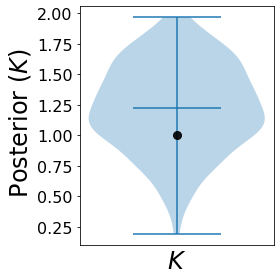

In [191]:
plt.figure(figsize=(4,4))
parts= plt.violinplot(K_posterior, widths=0.7, showmeans=True, showextrema=True);
plt.plot(1,params_true[-1] ,'o', color='k', alpha=0.9, markersize=8)
plt.ylabel(' Posterior ' +r'${(K)}$', fontsize=24);  
plt.xlabel(r'${K}$', fontsize=24); 
plt.yticks(fontsize=16)
plt.xticks([])
plt.tight_layout()
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SBI_BVEP_ode_obs3_InferredCoupling_K_"+str(K_true)+".png"), dpi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SBI_BVEP_ode_obs3_InferredCoupling_K_"+str(K_true)+".svg"), dpi=800)
plt.show()

In [192]:
estimated_posterior=np.percentile(posterior_samples, [50], axis=0).reshape(-1)    

In [193]:
y_fit_source =VEP2Dmodel(estimated_posterior, constants, init_conditions, dt, ts, SC)

yfit_source=y_fit_source.reshape(nn, int(y_fit_source.shape[0]/nn))

In [194]:
y_fit=yfit_source
y_fit.shape

(84, 141)

In [195]:
np.save(os.path.join(cwd+'/'+str(Res_dir), 'BVEP_ode_sbi_sourcelevel_obs3_patient1_y_obs.npy') , y_obs)
np.save(os.path.join(cwd+'/'+str(Res_dir), 'BVEP_ode_sbi_sourcelevel_obs3_patient1_y_obs.npy') , y_fit)

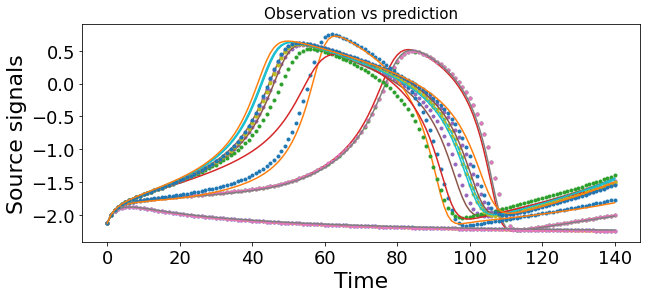

In [196]:
Rois=np.array([1, 5, 6, 11,18,  27, 34, 45, 50, 67, 81])

plt.figure(figsize=(10,4))
for roi in Rois:
    plt.plot(y_obs.T[:,roi], '.')
    plt.plot(y_fit.T[:,roi] )
plt.title("Observation vs prediction",fontsize=15)
plt.xlabel('Time', fontsize=22)
plt.ylabel('Source signals', fontsize=22)
plt.yticks(fontsize=18, rotation=0)
plt.xticks(fontsize=18, rotation=0)
plt.show()

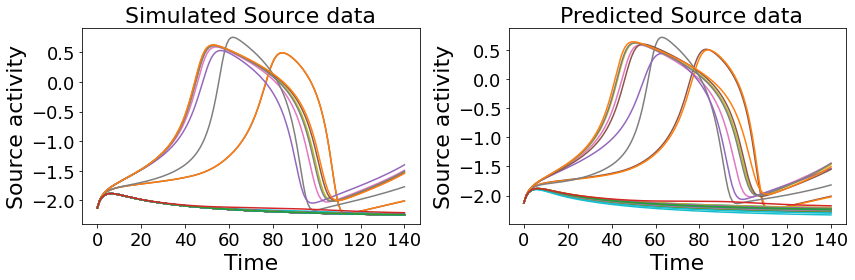

In [197]:
plt.figure(figsize=(12,4))

plt.subplot(121);
plt.plot(y_obs.T)
plt.title("Simulated Source data", fontsize=22) 
plt.xlabel('Time', fontsize=22)
plt.ylabel('Source activity', fontsize=22)
plt.yticks(fontsize=18, rotation=0)
plt.xticks(fontsize=18, rotation=0)

plt.subplot(122)
plt.plot(y_fit.T)
plt.title(" Predicted Source data", fontsize=22) 
plt.xlabel('Time', fontsize=22)
plt.ylabel('Source activity', fontsize=22)
plt.yticks(fontsize=18, rotation=0)
plt.xticks(fontsize=18, rotation=0)
plt.tight_layout()
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SBI_FittedBVEP_ode_obs3_observation_K_"+str(K_true)+".png"), dpi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SBI_FittedBVEP_ode_obs3_observation_K_"+str(K_true)+".svg"), dpi=800)
plt.show()

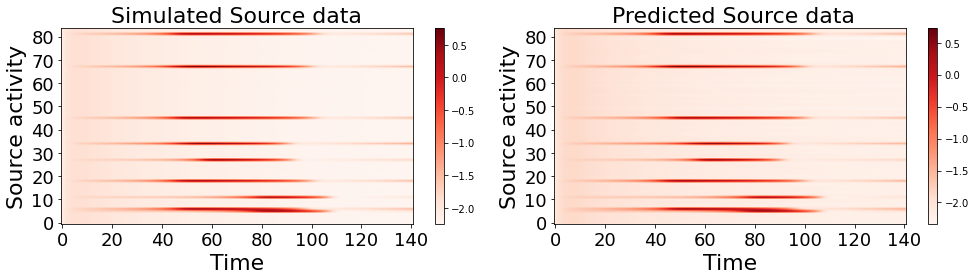

In [198]:
plt.figure(figsize=(14, 4))
plt.subplot(121);
plt.imshow(y_obs, aspect='auto', interpolation='bilinear',  origin='lower', cmap='Reds')
plt.title("Simulated Source data", fontsize=22) 
plt.xlabel('Time', fontsize=22)
plt.ylabel('Source activity', fontsize=22)
plt.yticks(fontsize=18, rotation=0)
plt.xticks(fontsize=18, rotation=0)
plt.colorbar();

plt.subplot(122)
plt.imshow(y_fit, aspect='auto', interpolation='bilinear',  origin='lower', cmap='Reds')
plt.title(" Predicted Source data", fontsize=22) 
plt.xlabel('Time', fontsize=22)
plt.ylabel('Source activity', fontsize=22)
plt.yticks(fontsize=18, rotation=0)
plt.xticks(fontsize=18, rotation=0) 
plt.colorbar();

plt.tight_layout()
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SBI_ImshowFittedBVEP_ode_obs3_observation_K_"+str(K_true)+".png"), dpi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SBI_ImshowFittedBVEP_ode_obs3_observation_K_"+str(K_true)+".svg"), dpi=800)
plt.show()

In [199]:
eta_true.shape, eta_posterior.shape

((84,), (200, 84))

In [200]:
true_labels_nodes,est_labels_nodes =SME_labels(eta_true, eta_posterior.transpose(), eta_c, delta_eta)

In [201]:
Confusion_matrix_values= confusion_matrix(true_labels_nodes, est_labels_nodes, labels=["EZ", "PZ", "HZ"])
print('Confusion_matrix_values= \n', Confusion_matrix_values)

Confusion_matrix_values= 
 [[ 6  0  0]
 [ 0  3  0]
 [ 0  0 75]]


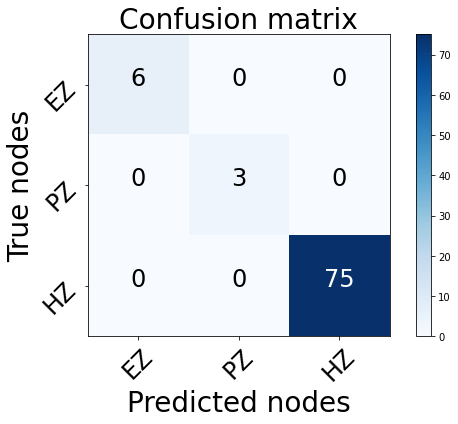

In [202]:
plt.figure(figsize=(8, 6))
plot_confusion_matrix(Confusion_matrix_values, ["EZ", "PZ", "HZ"])
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SBI_BVEP_ode_obs3_ConfusionMatrix_K_"+str(K_true)+".png"), dpi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SBI_BVEP_ode_obs3_ConfusionMatrix_K_"+str(K_true)+".svg"), dpi=800)
plt.tight_layout()
plt.show()

In [203]:
np.sum(np.std(eta_posterior, axis=0))

5.7990823

In [204]:
from report_metrics import LSE, Err, RMSE, LSE_obs, z_score, shrinkage

In [205]:
eta_est_mu=np.mean(eta_posterior, axis=0)
eta_est_std=np.std(eta_posterior, axis=0)

In [206]:
b=-7
a=-1
prior_std =np.sqrt((1/12)*(b-a)**2)

In [207]:
def plot_zscore_shrinkage(nodes, eta_true, eta_est_mu, eta_est_std, prior_std):
    z_score_eta=z_score(eta_true, eta_est_mu, eta_est_std)
    colors= np.random.rand(z_score_eta.shape[0])
    plt.scatter(shrinkage([prior_std]*nodes.shape[0], eta_est_std), z_score_eta ,s=120, c='blue')
    plt.xlabel("Posterior shrinkages", fontsize=24)
    plt.ylabel("Posterior z-scores", fontsize=24)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)

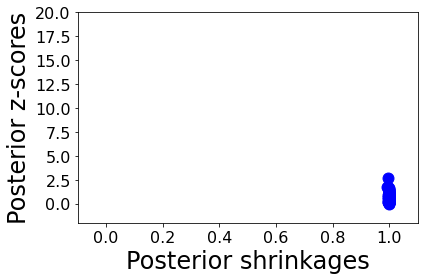

In [208]:
plot_zscore_shrinkage(nodes, eta_true, eta_est_mu, eta_est_std, prior_std)
plt.axis((-.1,1.1,-2,20))
plt.tight_layout()
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SBI_BVEP_ode_obs3_zscore_shrinkage_K_"+str(K_true)+".png"), dpi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SBI_BVEP_ode_obs3_zscore_shrinkage_K_"+str(K_true)+".svg"), dpi=800)
plt.show()

In [209]:
Err(eta_true, eta_est_mu), RMSE(eta_true, eta_est_mu)

(4.011952495574952, 0.0678665697100517)

In [210]:
Err(y_obs, y_fit), RMSE(y_obs, y_fit)

(191.08058396417164, 0.03800633540711989)

In [211]:
shrinkage([prior_std]*nodes.shape[0], eta_est_std).shape

(84,)

In [212]:
n_classes=3
node_classes=['HZ', 'PZ', 'EZ']

In [213]:
from sklearn import metrics
from itertools import cycle
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.preprocessing import label_binarize

In [214]:
true_nodes=true_node_binary(true_labels_nodes)
estimated_nodes=estimated_node_binary(est_labels_nodes)

In [215]:
y_true=label_binarize(true_nodes, classes=[0, 1, 2])
y_pred=label_binarize(estimated_nodes, classes=[0, 1, 2])

In [216]:
y_true.shape, y_pred.shape

((84, 3), (84, 3))

In [217]:
fpr = dict()
tpr = dict()
roc_auc = dict()


for i in range(n_classes):
    fpr[i], tpr[i], _ = metrics.roc_curve(y_true[:, i], y_pred[:, i])
    roc_auc[i] = metrics.auc(fpr[i], tpr[i])
    
# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = metrics.roc_curve(y_true.ravel(), y_pred.ravel())
roc_auc["micro"] = metrics.auc(fpr["micro"], tpr["micro"])    


all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = metrics.auc(fpr["macro"], tpr["macro"])

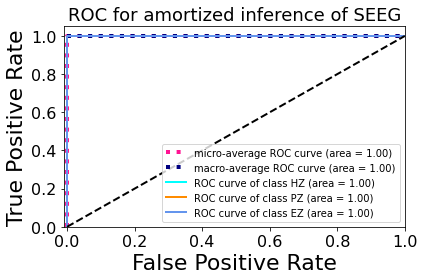

In [218]:
# Plot all ROC curves
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class '+ str(node_classes[i])+' (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([-.01, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=22)
plt.ylabel('True Positive Rate', fontsize=22)
plt.title('ROC for amortized inference of SEEG', fontsize=18)
plt.legend(loc="lower right")
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.tight_layout()
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"ROC_obs3_K_"+str(K_true)+".png"), dpi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"ROC_obs3_K_"+str(K_true)+".png"), dpi=800)
plt.show()

In [219]:
fpr

{0: array([0., 0., 1.]),
 1: array([0., 0., 1.]),
 2: array([0., 0., 1.]),
 'micro': array([0., 0., 1.]),
 'macro': array([0., 1.])}

In [220]:
tpr

{0: array([0., 1., 1.]),
 1: array([0., 1., 1.]),
 2: array([0., 1., 1.]),
 'micro': array([0., 1., 1.]),
 'macro': array([1., 1.])}

In [221]:
roc_auc["micro"], roc_auc["macro"]

(1.0, 1.0)